## Versions
Facility Location Model Versions:
* V1: Includes objective: transport costs
* V2: Includes allocation of locations to supply hubs
* V3: Includes objective: opening costs

EMA & Platypus optimisation Versions:
* V1: includes optimisation via Platypus
* V2: included model completely in ema_workbench environment
* V3: Working single run EMA
* V4: Implemented use of kwargs: Levers and case instantiation. Case is now instantiated outside model, by ema uncertainties and ema constant 

# Model XLRM

* External factors
* Levers
* Relations
* Metrics of performance

## System:

## External Factors: Define model

In [4]:
# Impact landscape --> Demand

## Levers 

In [5]:
# operational_facilities = [fl1,fl2,fl3,fl4]

# constraints:
# fl1,fl2,fl3,fl4: (0,1) # 0: not operational, 1: operational

## Relations 

## Metrics of performance

#### transportation costs

$$Transportation\_costs=\sum_{i=0}^{FL}\sum_{i=0}^{SP\&DP} distance_{FL,SP|DP} * costs$$

Calculates the costs of transportation between all facility locations to all supply and demand points 

# Model Python

## Pseudocode
    
    Model:
        FL Options: FL1,FL2,FL3, ..., FLn

        For option in options:
            allocate 
            calculate costs
            calculate times
            calculate coverage
            calculate xx
            
    Sequence of analysis:
        Initialise case (input1,input2,input3) #demand_landscape, 
        Optimise (obj1,obj2,obj3)
        Check Robustness (unc1,unc2,unc3)
        Implement best option

        Change uncertainties based on new information due to new FL
            Do this by reducing uncertainty the most for demand points closer to their preferred DC

## Model structure

In [1]:
# Imports
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import helper_functions as hf # helpful?

In [2]:
# Globals
size_area = 10
nr_demand_points = 10
nr_supply_points = 1
nr_optional_FL = 10
max_nr_FL = 2


#parameters costs
unit_transport_cost = 1
unit_opening_costs = 100


In [3]:
# Classes
class demand_class:
    """Demand points such as affected cities or villages"""

    def __init__(self, name):
        self.name = "DP{}".format(name)
        self.type = "demand"
        self.x = random.uniform(0, size_area)
        self.y = random.uniform(0, size_area)
        self.location = (self.x, self.y)

        # create random demand (random impacted area)
        self.demand = random.random() * 1000


class supply_class:
    """Supply points such as airports or seaports"""

    def __init__(self, name):
        self.name = "SP{}".format(name)
        self.type = "supply"
        self.x = random.uniform(0, size_area)
        self.y = random.uniform(0, size_area)
        self.location = (self.x, self.y)
        self.supply = random.random() * 1000
        self.operational = 1


class facility_class:
    """(Temporary) Distribution centers to distribute supply to demand"""

    def __init__(self, name):
        self.name = "FL{}".format(name)
        self.type = "facility"
        self.x = random.uniform(0, size_area)
        self.y = random.uniform(0, size_area)
        self.location = (self.x, self.y)
        self.operational = 0
    
    @property #test?
    def location2(self):
        return (self.x,self.y)


# Class is unneccessary
# class country:
#     """The combination of all demand and supply points and facility locations"""

#     def __init__(self, name):
#         self.name = name

### Instantiate model

In [4]:
# Instantiate model

# Create airport as a supply point
supply_points = []
for i in range(nr_supply_points):
    supply_points.append(supply_class(name=i))

# Create demand points
demand_points = []
for i in range(nr_demand_points):
    demand_points.append(demand_class(name=i))

# Create possible facility locations
facility_locations = []
for i in range(nr_optional_FL):
    facility_locations.append(facility_class(name=i))

$Allocation\_matrix:  A$

$Distance\_matrix:  D$

In [5]:
# Organise all nodes and create distance matrix
all_nodes = supply_points + facility_locations + demand_points
nr_nodes = len(all_nodes)

# distance matrix
distances = np.zeros([nr_nodes, nr_nodes])

def calculate_distance(x1, y1, x2, y2):
    dx = x1 - x2
    dy = y1 - y2
    return (dx**2 + dy**2)**0.5




# # validated: calculate_distance function
# calculate_distance (-1,-1,2,3)
# #returns 5.0. # dx = 3, dy = 4 --> distance = 5


# calculate distance matrix
for i in range(len(all_nodes)):
    # Give all nodes in model an identifier corresponding to position in matrix
    all_nodes[i].id = i
    for j in range(len(all_nodes)):
        dist_ij = calculate_distance(all_nodes[i].x, all_nodes[i].y,
                                     all_nodes[j].x, all_nodes[j].y)
        distances[i, j] = dist_ij

# set distance to self to big distance
max_dist = distances.max()
for i in range(len(distances)):
    distances[i,i] = max_dist * 100

In [6]:
# Set one of the FLs on operational to test
facility_locations[7].operational = 1
print("These hubs are operational:", [a.id for a in supply_points + facility_locations if a.operational is 1])

These hubs are operational: [0, 8]


In [7]:
# allocate each demand point to either a supply point or a facility location
def allocate(supply_points, demand_points, facility_locations, distances):
    """
    Returns an allocation matrix for [n,h]
    if [n,h] is 1: node n is allocated to supply hub h
    The full size of the matrix is n*n
    indexes are based on node.id
    
    Assumptions:
    All allocations are made based on the minimum distance
    Supply points are not allocated to other nodes, since they are supplied by upstream logistics, which is out of scope    
    """

    # list of all IDs for operational supply points and facility locations
    operational_hubs_id = [
        a.id for a in supply_points + facility_locations if a.operational is 1
    ]

    #allocation matrix of all_nodes x all_nodes
    allocation_matrix = np.zeros([len(all_nodes), len(all_nodes)])

    # for each operational facility location:
    # we skip supply points, because we don't consider upstream logistics
    for fl in [fl for fl in facility_locations if fl.operational is 1]:
        # choose one of other operational hubs that is closest (distance to iself is made very large while creating distance matrix)
        closest_i = np.argmin(
            [distances[hub_id, fl.id] for hub_id in operational_hubs_id])
        # allocate me to that hub
        allocation_matrix[fl.id, operational_hubs_id[closest_i]] = 1

    # For each demand point
    for dp in demand_points:
        # Assumption: Each demand point gets 1 location allocated. If 2 locations have same distance, choose first
        # check which supply point or facility location is closest
        # closest = the index of the minimum distance of the list of distances between this demand point and all supply points
        closest_i = np.argmin(
            [distances[hub_id, dp.id] for hub_id in operational_hubs_id])

        # Set allocation 1 if j is closest to this demand point (or i)
        #i: demand point index, j: supply point index
        allocation_matrix[dp.id, operational_hubs_id[closest_i]] = 1

    return allocation_matrix

In [8]:
allocation_matrix = allocate(supply_points,demand_points,facility_locations,distances)

In [14]:
# OLD function calculate transportation costs
def calc_transportation_costs_old(supply_points, demand_points,
                               facility_locations, distances):
    """
    TODO: write description
    This old function calculates costs assuming 1 operational location
    It also assumes that the supply point only delivers to the FL
    """
    # create variable representing costs
    transport_costs = 0
    # For each facility location
    for fl in facility_locations:
        # for each operational facility location
        if fl.operational == 1:
            #for each supply and demand point
            for a in supply_points + demand_points:
                #add costs of transportation
                transport_costs = transport_costs + distances[a.id, fl.
                                                              id] * unit_transport_cost

    return transport_costs


# requires validation

In [40]:
def calc_costs():

    # calc opening costs of facilities
    # assumption: supply point, i.e. airport, is already opened
    opened_fl = sum([fl.operational for fl in facility_locations])
    total_opening_costs = opened_fl * unit_opening_costs

    # Calc transportation costs
    total_distance = (allocation_matrix * distances).sum()
    transportation_costs = total_distance * unit_transport_cost

    
    # Calc social costs
    # TODO
    # Now social logistics costs is included in transportation cost

    return total_opening_costs + transportation_costs

In [42]:
calc_costs()

145.21196945843616

In [18]:
# # Objective functions
# # opening costs: objective from gutjahr & Dzubur 2016
# # costs = construction_costs + transportation_costs

# # objective 1

# construction_costs = 0
# transportation_costs = calc_transportation_costs
# costs = transportation_costs + construction_costs
# minimise(costs)

# Case results 

In [29]:
# # test to check optimisation
# for i in facility_locations:
#     i.operational = 1

#     print(i.name,i.id,
#           calc_transportation_costs(supply_points, demand_points,
#                                     facility_locations, distances))

#     i.operational = 0

## Graphical representation of case

### Creating allocation lines

In [33]:
allocation_lines = np.zeros([len(all_nodes), 4])
# creates matrix x1,y1,x2,y2
for i, line in enumerate(zip(allocation_matrix)):
    if allocation_matrix[i].sum() == 0:
        continue
    allocation_lines[i, 0:2] = list(all_nodes[i].location)
    # Assumption: Only 1 location allocated # if changing: loop over list comprehension: [more than 0 allocated]
    allocation_lines[i, 2:4] = list(
        (all_nodes)[np.argmax(line)].location)

In [34]:
allocation_lines

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [1.86105512, 0.66703163, 0.83677107, 3.9570269 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [1.96063773, 3.66246539, 0.83677107, 3.9570269 ],
       [6.76720687, 1.9222047 , 1.86105512, 0.66703163],
       [7.63748162, 9.11832568, 0.83677107, 3.9570269 ],
       [3.14217672, 1.99387299, 1.86105512, 0.66703163],
       [5.81605197, 6.88285141, 0.83677107, 3.9570269 ],
       [8.74987993, 6.20117727, 0.83677107, 3.9570269 ],
       [0.78799731, 1.59283441,

### Plotting Locations and allocations

yes


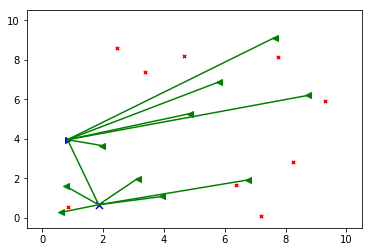

In [36]:
plt.axis([-0.5,10.5,-0.5,10.5])

for x in demand_points:
    plt.scatter(x.x, x.y,c="green",marker="<")
for x in facility_locations:
    if x.operational == 0:
        plt.scatter(x.x, x.y,c="red", marker="x",s=10)
    if x.operational == 1:
        print("yes")
        plt.scatter(x.x, x.y,c="blue", marker="x",s=50)
for x in supply_points:
    plt.scatter(x.x, x.y,c="blue", marker=">")

# plot allocation lines

for line in allocation_lines:
    plt.plot(line[[0,2]], line[[1,3]], c="green")

# plt.plot([0,4], [8,9])


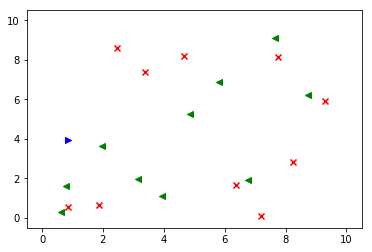

In [39]:
plt.axis([-0.5,10.5,-0.5,10.5])

for x in demand_points:
    plt.scatter(x.x, x.y,c="green",marker="<")
for x in facility_locations:
#     if x.operational == 1:
    plt.scatter(x.x, x.y,c="red", marker="x")
for x in supply_points:
    plt.scatter(x.x, x.y,c="blue", marker=">")


# EMA model evaluator



## EMA pseudocode
    
    Define classes
    Generate case
        create locations
    Load EMA model
        specifies:
            demand landscape
            unit transport costs
            unit opening costs
            Max nr of FL to be opened
        calculates
            allocation
            distances
            objectives

In [6]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import ema_workbench as em
from ema_workbench import (Model, RealParameter, IntegerParameter, Constant, ScalarOutcome, ema_logging,
                           perform_experiments, Scenario, Policy)

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Model

### Define classes and Case settings

In [8]:
# Classes
class demand_class:
    """Demand points such as affected cities or villages"""

    def __init__(self, name, x, y, demand):
        self.name = "DP{}".format(name)
        self.type = "demand"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.demand = demand


class supply_class:
    """Supply points such as airports or seaports"""

    def __init__(self, name, x, y, supply):
        self.name = "SP{}".format(name)
        self.type = "supply"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.supply = supply
        self.operational = 1


class facility_class:
    """(Temporary) Distribution centers to distribute supply to demand"""

    def __init__(self, name, x, y):
        self.name = "FL{}".format(name)
        self.type = "facility"
        self.x = x
        self.y = y
        self.location = (self.x, self.y)
        self.operational = 0


# Case settings / Globals
# size_area = 10
# nr_demand_points = 10
# nr_supply_points = 1
# nr_optional_FL = 10

### Functions for Instantiating case and calculating objectives

In [13]:
supply_kwarg = {"keysSupply":"valuesSupply"}
demand_kwarg = {"keysDemand":"valuesDemand"}
FL_kwarg = 
# all_kwargs = {"supply"}
# {"key": "value"}
# d = {key: value for (key, value) in iterable}

In [16]:
supply_kwarg['keysSupply']

'valuesSupply'

In [84]:
#testing
create_supply_points(sup_xcors,sup_ycors)

In [520]:
# Instantiate case functions
# Instantiate model


# Create airport as a supply point
def create_supply_points(sup_xcors, sup_ycors, supply_at_sp=100):

    #TODO get a list with specific supply values for each point
    supply_at_sps = [supply_at_sp for i in range(len(sup_xcors))]

    supply_points = []
    for i in range(len(sup_xcors)):
        supply_points.append(
            supply_class(
                name=i,
                x=sup_xcors[i],
                y=sup_ycors[i],
                supply=supply_at_sps[i]))
    return supply_points


# Create demand points
def create_demand_points(dp_xcors, dp_ycors, demand_at_dp=10):

    demand_at_dps = [demand_at_dp for i in range(len(dp_xcors))]

    demand_points = []
    for i in range(len(dp_xcors)):
        demand_points.append(
            demand_class(
                name=i, x=dp_xcors[i], y=dp_ycors[i], demand=demand_at_dps[i]))
    return demand_points


# # Create possible facility locations
def create_facility_locations(fl_xcors, fl_ycors):

    facility_locations = []
    for i in range(len(fl_xcors)):
        facility_locations.append(
            facility_class(name=i, x=fl_xcors[i], y=fl_ycors[i]))
    return facility_locations


# Create matrix with all distances
def create_distance_matrix(all_nodes):
    """
    Creates a matrix with distances between all nodes
    Input: list of all nodes (objects)
    Output: Matrix with distances from [i,j]
    i,j = from, to
    Note: Matrix is symmetric: distances[i,j] = distances[j,i]
    Note: Distance to self ([i,i]) is 100 times larger than largest distance in matrix
    """
    distances = np.zeros([len(all_nodes), len(all_nodes)])

    def calculate_distance(x1, y1, x2, y2):
        dx = x1 - x2
        dy = y1 - y2
        return (dx**2 + dy**2)**0.5

    # calculate distance matrix
    for i in range(len(all_nodes)):  #For every row
        for j in range(len(all_nodes)):  #For every column
            distances[i, j] = calculate_distance(
                all_nodes[i].x, all_nodes[i].y, all_nodes[j].x, all_nodes[j].y)

    # set distance to self to big distance
    for i in range(len(distances)):
        distances[i, i] = distances.max() * 100

    return distances


# allocate each demand point to either a supply point or a facility location
def create_allocation_matrix(supply_points, demand_points, facility_locations,
                             distances):
    """
    Returns an allocation matrix for [n,h]
    if [n,h] is 1: node n is allocated to supply hub h
    The full size of the matrix is n*n
    indexes are based on node.id
    
    Assumptions:
    All allocations are made based on the minimum distance
    Supply points are not allocated to other nodes, since they are supplied by upstream logistics, which is out of scope    
    """

    # list of all IDs for operational supply points and facility locations
    operational_hubs_id = [
        a.id for a in supply_points + facility_locations if a.operational == 1
    ]
    print("op_ids", operational_hubs_id)
    
    all_nodes = supply_points + facility_locations + demand_points
    #allocation matrix of all_nodes x all_nodes
    allocation_matrix = np.zeros([len(all_nodes), len(all_nodes)])

    # for each operational facility location:
    # we skip supply points, because we don't consider upstream logistics
    for fl in [fl for fl in facility_locations if fl.operational == 1]:
        # choose one of other operational hubs that is closest (distance to iself is made very large while creating distance matrix)
        closest_i = np.argmin(
            [distances[hub_id, fl.id] for hub_id in operational_hubs_id])
        # allocate me to that hub
        allocation_matrix[fl.id, operational_hubs_id[closest_i]] = 1

    # For each demand point
    for dp in demand_points:
        # Assumption: Each demand point gets 1 location allocated. If 2 locations have same distance, choose first
        # check which supply point or facility location is closest
        # closest = the index of the minimum distance of the list of distances between this demand point and all supply points
        closest_i = np.argmin(
            [distances[hub_id, dp.id] for hub_id in operational_hubs_id])

        # Set allocation 1 if j is closest to this demand point (or i)
        #i: demand point index, j: supply point index
        allocation_matrix[dp.id, operational_hubs_id[closest_i]] = 1

    return allocation_matrix


def calc_costs(facility_locations, unit_opening_costs, unit_transport_cost,
               distances, allocation_matrix):
    # calc opening costs of facilities
    # assumption: supply point, i.e. airport, is already opened
    nr_opened_fl = sum([fl.operational for fl in facility_locations])
    total_opening_costs = nr_opened_fl * unit_opening_costs

    # Calc transportation costs
    total_distance = (allocation_matrix * distances).sum()
    transportation_costs = total_distance * unit_transport_cost

    # Calc social costs
    # TODO
    # Now social logistics costs is included in transportation cost

    return total_opening_costs + transportation_costs

In [521]:
# Functions for plotting
def plotting_create_allocation_lines(all_nodes, allocation_matrix):

    allocation_lines = np.zeros([len(all_nodes), 4])
    # creates matrix x1,y1,x2,y2
    for i, line in enumerate(zip(allocation_matrix)):
        if allocation_matrix[i].sum() == 0:
            continue
        allocation_lines[i, 0:2] = list(all_nodes[i].location)
        # Assumption: Only 1 location allocated # if changing: loop over list comprehension: [more than 0 allocated]
        allocation_lines[i, 2:4] = list((all_nodes)[np.argmax(line)].location)

    return allocation_lines


def plotting_plot_map(demand_points,
                      facility_locations,
                      supply_points,
                      allocation_lines=False):

    plt.axis([-0.5, 10.5, -0.5, 10.5])

    for x in demand_points:
        plt.scatter(x.x, x.y, c="green", marker="<")

    for x in facility_locations:
        if x.operational == 0:
            plt.scatter(x.x, x.y, c="red", marker="x", s=10)
        if x.operational == 1:
            print("mark1")
            plt.scatter(x.x, x.y, c="blue", marker="x", s=50)
    for x in supply_points:
        plt.scatter(x.x, x.y, c="blue", marker=">")

    # plot allocation lines
    if allocation_lines is not False:
        for line in allocation_lines:
            plt.plot(line[[0, 2]], line[[1, 3]], c="green")

    # plt.plot([0,4], [8,9])

2

In [565]:
def FL_model(dec_vars,
             nr_supply_points,
             nr_demand_points,
             nr_optional_FL,
             size_area,
             unit_opening_costs,
             unit_transport_cost,
             graphical_representation=False,
             **kwargs):

    #unpack kwargs
    keys = sorted(kwargs.keys())
    sp_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'SPX']]
    sp_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'SPY']]
    dp_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'DPX']]
    dp_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'DPY']]
    fl_xcors = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLX']]
    fl_ycors = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLY']]

    fl_operational = [kwargs[x] for x in [k for k in keys if k[:3] == 'FLO']]

    #     sup_xcors = [locations['SPX{}'.format(i)] for i in range (len(locations))]
    #     sup_xcors = [locations["SPX{}".format(i)] for i in range (len(locations))]
    #     sup_ycors = [locations['SPY{}'.format(i)] for i in range (len(locations))]

    # set up model

    supply_points = create_supply_points(sp_xcors, sp_ycors)
    demand_points = create_demand_points(dp_xcors, dp_ycors)
    facility_locations = create_facility_locations(fl_xcors, fl_ycors)

    # Organise all nodes and create distance matrix
    all_nodes = supply_points + facility_locations + demand_points
    # Give all nodes in model an identifier corresponding to position in matrix
    for i in range(len(all_nodes)):
        all_nodes[i].id = i

    # Check if things are right
    if len(facility_locations) != len(fl_operational):
        print("Length FL arrays not equal, FL_model:", len(facility_locations),
              len(fl_operational))

    # Set operational FLs from levers
    for i, fl in enumerate(facility_locations):
        fl.operational = fl_operational[i]


    distances = create_distance_matrix(all_nodes)
    allocation_matrix = create_allocation_matrix(supply_points, demand_points,
                                                 facility_locations, distances)

    # determine objectives
    total_costs = calc_costs(facility_locations, unit_opening_costs,
                             unit_transport_cost, distances, allocation_matrix)

    # give a graphical representation of instantiation and allocation
    if graphical_representation == True:
        allocation_lines = plotting_create_allocation_lines(
            all_nodes, allocation_matrix)

        plotting_plot_map(demand_points, facility_locations, supply_points,
                          allocation_lines)
        print("TODO, Close figure")
        plt.show()

    print(allocation_matrix)
    return total_costs, sum([fl.operational for fl in facility_locations])

In [488]:
SPX = {"SPX{}".format(i): random.uniform(0,10) for i in range(1)}
SPY = {"SPY{}".format(i): random.uniform(0,10) for i in range(1)}
DPX = {"DPX{}".format(i): random.uniform(0,10) for i in range(5)}
DPY = {"DPY{}".format(i): random.uniform(0,10) for i in range(5)}
FLX = {"FLX{}".format(i): random.uniform(0,10) for i in range(6)}
FLY = {"FLY{}".format(i): random.uniform(0,10) for i in range(6)}

FLO={"FLO0":0,"FLO1":0,"FLO2":0,"FLO3":1,"FLO4":0,"FLO5":0}

6 6
op_ids [0, 4]
mark1
TODO, Close figure


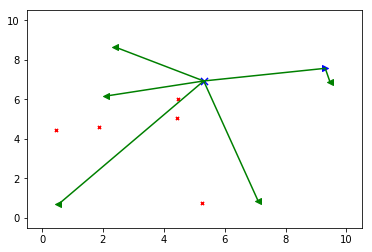

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


(125.65920850610723, 1)

In [562]:
FL_model('dec_vars_go_here', 1, 10, 10, 10, 100, 1, True, **SPX, **SPY, **DPX,**DPY,**FLX,**FLY,**FLO)
# print("gelukt, nu weer verder")

In [54]:
# Decision parameters
# max_nr_FL = 2




In [538]:
# Meta parametric variables
nr_of_SPs = 1
nr_of_DPs = 10
nr_of_FLs = 6

#Instantiate EMA model
FL_EMAmodel = Model('flmodel', function=FL_model)

#Specify constants
FL_EMAmodel.constants = [
    Constant('dec_vars', False),
    Constant('nr_supply_points', 1),
    Constant('nr_demand_points', 10),
    Constant('nr_optional_FL', 10),
    Constant('size_area', 10),
    Constant('unit_opening_costs', 100),
    Constant('unit_transport_cost', 1),
    Constant('graphical_representation', True)
]

#Specify coordinates of locations
# 0 - size area, range nr supply points
FL_EMAmodel.locations = [
    RealParameter("SPX{}".format(i), 0, 10) for i in range(nr_of_SPs)
] + [RealParameter("SPY{}".format(i), 0, 10) for i in range(nr_of_SPs)] + [
    RealParameter("DPX{}".format(i), 0, 10) for i in range(nr_of_DPs)
] + [RealParameter("DPY{}".format(i), 0, 10) for i in range(nr_of_DPs)] + [
    RealParameter("FLX{}".format(i), 0, 10) for i in range(nr_of_FLs)
] + [RealParameter("FLY{}".format(i), 0, 10) for i in range(nr_of_FLs)]

#Specify uncertainties
FL_EMAmodel.uncertainties = FL_EMAmodel.locations
#     RealParameter('FL_x_cor_0', 0, areasize),
#     RealParameter('FL_x_cor_1', 0, areasize),
#     RealParameter('FL_y_cor_0', 0, areasize),
#     RealParameter('FL_y_cor_1', 0, areasize),
#     RealParameter('x', 0, 1),
#     RealParameter('x', 0, 1)
# ]

# # Specify levers
# Facility Location Operational: [0,1]
FL_EMAmodel.levers = [IntegerParameter("FLO{}".format(i), 0, 1) for i in range(nr_of_FLs)]

# FL_EMAmodel.c

# Specify outcomes
FL_EMAmodel.outcomes = [
    ScalarOutcome('Total_cost'),
    #     ScalarOutcome('message_string'),
    ScalarOutcome('operational_FL')
]

In [539]:
from ema_workbench.em_framework import sample_levers

samples = sample_levers(FL_EMAmodel, 10)

for sample in samples:
    print(sample)


{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}
{'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0}


0 0
op_ids []
TODO, Close figure


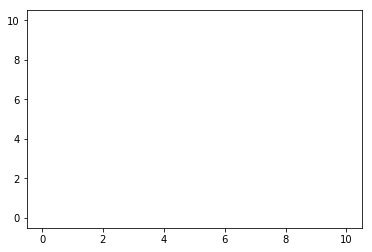

[]


In [561]:
FL_EMAmodel.run_model(Scenario(), Policy({}))

[MainProcess/INFO] performing 2 scenarios * 2 policies * 1 model(s) = 4 experiments
[MainProcess/INFO] performing experiments sequentially


6 6
op_ids [0, 1, 2, 3]
mark1
mark1
mark1
TODO, Close figure


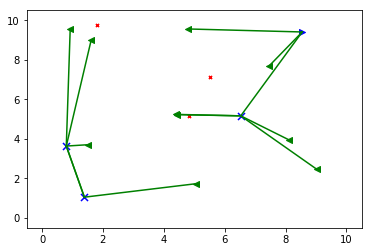

[MainProcess/INFO] 1 cases completed


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
6 6
op_ids [0, 1, 2, 3]
mark1
mark1
mark1
TODO, Close figure


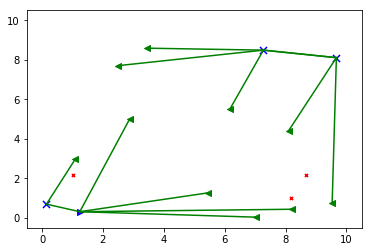

[MainProcess/INFO] 2 cases completed


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
6 6
op_ids [0, 4, 5, 6]
mark1
mark1
mark1
TODO, Close figure


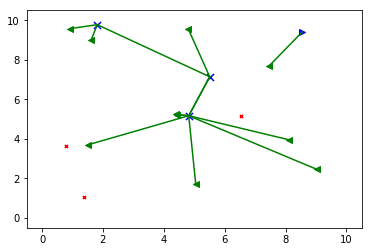

[MainProcess/INFO] 3 cases completed


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
6 6
op_ids [0, 4, 5, 6]
mark1
mark1
mark1
TODO, Close figure


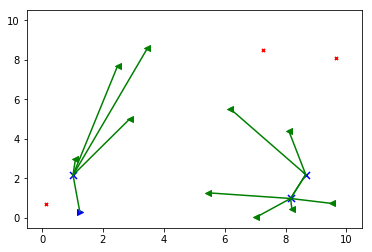

[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] experiments finished


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [533]:
from ema_workbench import Policy, perform_experiments

results = perform_experiments(FL_EMAmodel, 2,2)
experiments, outcomes = results

In [527]:
pd.DataFrame(experiments)#[["FLO0","FLO1","FLO2","FLO3"]]

,DPX0,DPX1,DPX2,DPX3,DPX4,DPX5,DPX6,DPX7,DPX8,DPX9,...,SPY0,FLO0,FLO1,FLO2,FLO3,FLO4,FLO5,scenario_id,policy,model
0,3.264711,9.650825,1.294703,2.157435,1.445244,3.563416,6.283035,7.460475,1.309823,7.675739,...,5.197106,0,1,1,1,1,1,91,"{'FLO0': 0, 'FLO1': 1, 'FLO2': 1, 'FLO3': 1, '...",flmodel
1,5.301885,3.119100,6.018172,6.322771,7.448395,5.234246,1.839807,3.904056,8.608461,4.991776,...,2.619243,0,1,1,1,1,1,92,"{'FLO0': 0, 'FLO1': 1, 'FLO2': 1, 'FLO3': 1, '...",flmodel
2,3.264711,9.650825,1.294703,2.157435,1.445244,3.563416,6.283035,7.460475,1.309823,7.675739,...,5.197106,1,0,0,0,0,0,91,"{'FLO0': 1, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, '...",flmodel
3,5.301885,3.119100,6.018172,6.322771,7.448395,5.234246,1.839807,3.904056,8.608461,4.991776,...,2.619243,1,0,0,0,0,0,92,"{'FLO0': 1, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, '...",flmodel


In [450]:
pd.DataFrame(outcomes)

,Total_cost,operational_FL
0,335.970076,3.0
1,347.765237,3.0
2,335.970076,3.0
3,347.765237,3.0


In [125]:
[i for i in FL_EMAmodel.levers]

[]

In [ ]:
FL_EMAmodel.retrieve_output

In [1]:
0

0

# Platypus optimisation

In [14]:
# imports
from platypus import NSGAII, Problem, Binary, Real, Integer

In [10]:
def FL_model(d_vars=None): # None to make compatible with EMA

    # set global operational FL
    for i in range(len(d_vars)):
        facility_locations[i].operational = d_vars[i]

    trans_costs = calc_transportation_costs(supply_points, demand_points,
                                      facility_locations, distances)

    costs = trans_costs #+ other costs
    
    objectives = [
        costs,
    ]
    constraints = [sum(d_vars),]

    return objectives, constraints

In [54]:
# nr of decision variables, number of objectives, number of constraints
problem = Problem(nr_optional_FL, 1, 1)

# Decision variables for possible facility locations
problem.types[:] = [Integer(0,1) for a in range(nr_optional_FL)]

# constraint: number of total operation FL
problem.constraints[:] = "=={}".format(max_nr_FL)
problem.function = FL_model

algorithm = NSGAII(problem)
algorithm.run(10000)

'==2'

In [17]:
from platypus import nondominated

In [55]:
a = nondominated (algorithm.result)

In [57]:
a

[Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.98869101013045|0.0],
 Solution[[False],[True],[False],[False],[False],[False],[False],[False],[True],[False]|68.9886910101304

In [56]:
for i in a[0].objectives:
    print(i)

68.98869101013045


In [44]:
a[0].objectives[0]

33.50099827255527

In [46]:
set([i.objectives[0] for i in a])

{33.50099827255527}

# Next steps

Choices:
- Capacitated vs uncapacitated?
- Endogenous vs exogenous number of facilities each optimisation step 
    - each increment: exogenous
    - Full network: endogenous

Do:
- Assign demand points to closest facilities (:allocation) - Done
- optimise with only distance to linked demand points - Done
- set up with EMA - Now
    - 1. be able to run single
        - specific Scen: uncertainties: Case instantiation
        - specific Pol
    - 2. be able to run multi 
        - multi scen
        - multi pol
- Coverage
- allocation: make sure all FL are connected to a SP
- social costs
- equity

How:
- create for each demand class a "allocated facility"
- Only add costs for distances between "linked" demand-facility points
- look at paper guthjahr? user equilibrium?

In [ ]:
temp todo
make single run with specific scenario (case) and specific policy(FL)